# A basic notebook for stacking NN predictions

In [1]:
import pylab as p
from numpy import *
import pandas as pd
from tqdm import tqdm
import xgboost as xgb
from sklearn.preprocessing import minmax_scale
from sklearn.metrics import log_loss as skl_log_loss
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import roc_auc_score as skl_roc_auc_score

### Custom functions

In [2]:
def my_log_loss(ytrue, ypred):
    ll = zeros(6)
    for i in range(6):
        ll[i] = skl_log_loss(ytrue[:,i], ypred[:,i])
    return ll.mean()

### Read in the original data

In [3]:
# Read in the TOXIC competition data
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')

# Target labels
ycols = train.columns[2:]
ys = train[ycols].values

print('Reading the challenge data...')
print( '%-27s %-10i' % ('Size of the training set:', len(train)))
print( '%-27s %-10i' % ('Size of the testing set:', len(test)))
print()

Reading the challenge data...
Size of the training set:   159571    
Size of the testing set:    153164    



### Read in the master data file

In [4]:
master_list = pd.read_csv('../xmodel_list.txt', delim_whitespace=True, names=['id', 'logloss', 'roc'])

print('Found %i models in the master list.' % len(master_list))

Found 44 models in the master list.


### Read in all available NN predictions

In [5]:
%%time 
dfs = zeros((len(master_list), train.shape[0], 6))
dds = zeros((len(master_list), test.shape[0], 6))
for i,v in enumerate(tqdm(master_list['id'].values, desc='Loading models...')):
    try:
        dfs[i] = pd.read_csv('../xvalidations/'+v[:-1]+'.csv.bz', compression='bz2')[ycols].values
        dds[i] = pd.read_csv('../xsubmissions/'+v[:-1]+'.csv')[ycols].values
    except:
        print('Model', v, 'failed to load.')


Loading models...: 100%|██████████| 44/44 [00:30<00:00,  1.43it/s]

CPU times: user 29.6 s, sys: 1.13 s, total: 30.7 s
Wall time: 30.7 s


Optional minmax scaling of the output columns

In [6]:
# # The scaling (overwritting the original stuff, in memory of course)
# for i range(len(dfs)):
#     dfs[i] = minmax_scale(dfs[i])
#     dds[i] = minmax_scale(dds[i])

### Choose the best models (optional)
 - this was done in the bagging notebook

In [6]:
# best_models = array([ 0,  1,  5,  7,  9, 11, 13, 16, 25, 26, 27, 31, 32])

# # Choose only the relevant models
# dftrain = dftrain[best_models]
# dftest  = dftest[best_models]

# print('Best local roc:', skl_roc_auc_score(ys, dftrain.mean(axis=0) ))

Best local roc: 0.992346193102586 (this is with minmax_scale tho)

### Prepare the data for the training process
- for now use all the available data, for everything.. Kinda messy, but let's see... trees should be insensitive to uninformative features..
- the `hstack` converts the dftrain into a format where columns from the different models are collapsed into a single model

In [7]:
# X = hstack(dftrain)
# Y = hstack(dftest)

X = hstack(dfs)
Y = hstack(dds)

## Stacking with  `XGBoost`

In [13]:
# My own xgboost model class, useful for training stuff on the fly, with x-validations and all

class xgboost_model():
    def __init__(self, X, Y):
        '''
        params:
        X = dMatrix for the complete training set
        Y = dMatric for the complete test set
        '''
        self.X = X
        self.Y = Y
        
    def run_xgboost_model(self, params, num_boost_round, num_folds=8, verbose_eval=False, show_plot=True):
        
        # The KFold object
        kf = KFold(n_splits=num_folds, shuffle=False, random_state=None)
        
        # The history for the plots
        hh = tmp = [{} for _ in range(num_folds)]
        
        # metrics
        val_loss = zeros(num_folds)
        val_roc = zeros(num_folds)
        
        # predictions on the validation set
        vvpred = zeros(num_folds, dtype='O')
        
        # The test results predictions from each fold
        pred = zeros((num_folds, 153164))
        
        # The training the KFold x-validation starts here
        for i, (ind_train, ind_val) in enumerate(kf.split(self.X.get_label())):
            XX, VV = self.X.slice(ind_train), self.X.slice(ind_val)
            
            # The booster model for the given data
            booster = xgb.train(params=params, 
                                dtrain=XX, 
                                num_boost_round=num_boost_round, 
                                evals=[(XX,'train'),(VV,'val')], 
                                evals_result=hh[i],
                                early_stopping_rounds=17,
                                learning_rates=self.learning_rate_decay,
                                verbose_eval=verbose_eval)
            
            # Predictions on the validation set
            vvpred[i] = booster.predict(VV)
                        
            # Record the metrics
            val_loss[i] = skl_log_loss(VV.get_label(), vvpred[i])
            val_roc[i] = skl_roc_auc_score(VV.get_label(), vvpred[i])
            print(val_roc[i])
            
            # Predictions onthe test set
            pred[i] = booster.predict(self.Y)

        # Plot the loss function as a diagnostic
        if show_plot:
            p.figure(figsize=(9,6))
            for i in range(num_folds):
                p.plot((hh[i]['train']['logloss']), lw=2, ls='solid')
                p.plot((hh[i]['val']['logloss']), lw=2, ls='dashed')
            p.show()
        
        # Collect the results
        print()
        print('Average logloss across the x-validation folds: %2.6f' % (val_loss.mean()))
        print('Average roc-auc across the x-validation folds: %2.6f' % (val_roc.mean()))
        
        # Stack the predictions from the validation and test sets
        vvpred = hstack(vvpred)
        pred = pred.mean(axis=0)
        
        return vvpred, pred

    def learning_rate_decay(self, i, itotal):
        if (i<=10):
            lr = 0.2
        elif (10<i) & (i<=100):
            lr = 0.1
        elif (100<i) & (i<=300):
            lr = 0.05
        elif (300<i) & (i<=500):
            lr =  0.01
        elif (500<i) & (i<=1000):
            lr = 0.005
        else:
            lr = 0.001

        return lr


Predicting toxic comments
0.98828872629785
0.9897591889089814
0.9881774882106567
0.9888682874414749
0.9898907547557952
0.98876846597186
0.9876817613513812
0.9896961224095691


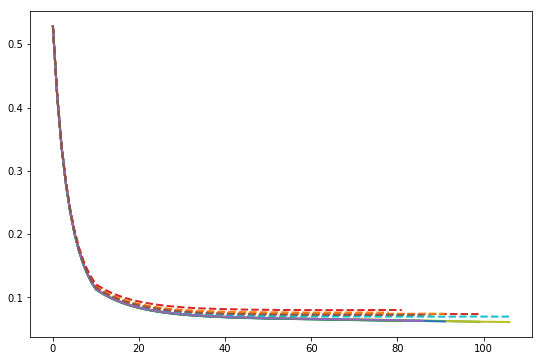


Average logloss across the x-validation folds: 0.074172
Average roc-auc across the x-validation folds: 0.988891


CPU times: user 19min 8s, sys: 7.8 s, total: 19min 16s
Wall time: 2min 32s


In [47]:
%%time

# This cell runs the xgboost_model stacking the outputs of the different models

# The parameters for the training process
params = {
    'max_depth': 5,
    'learning_rate': 0.2,
    'min_child_weight': 1,
    'subsample': 0.5,
    'colsample_bytree': 0.7, # subsample ratio of columns when constructing each tree.
    'colsample_bylevel' :0.4,  # subsample ratio of columns for each split, in each level.
    'reg_lambda': 0.5,         # L2 norm
    'reg_alpha:': 0.0,         # L1 norm
    'objective': 'binary:logistic',
    'eval_metric': 'logloss'
}

# This is where the outputs are stored
xgb_vvpred = zeros((len(ycols), X.shape[0]))
xgb_pred   = zeros((len(ycols), Y.shape[0]))

# Converting the test set to xgboost friendly format
dtest  = xgb.DMatrix(data=Y)

for i,v in enumerate(ycols[:1]):
    print('Predicting %s comments' % (v))
    # Converting the training set to xgboost friendly format 
    dtrain = xgb.DMatrix(data=X, label=ys[:,i])
    # instantiating my own xgboost_model class
    booster = xgboost_model(X=dtrain, Y=dtest)
    xgb_vvpred[i], xgb_pred[i] = booster.run_xgboost_model(params=params, num_boost_round=500, num_folds=8)
    print('')
    print('')

# print('')
# print('Saving the final results to disk...')
# # Save to disk the prediction for the training set from the x-validation folds
# df_valid = train.copy()
# df_valid[ycols] = pd.DataFrame(xgb_vvpred.T, columns=ycols)
# df_valid.to_csv('./xgb_xval_stack.csv', index=False)

# # Creating the submission file
# submission = pd.read_csv('../sample_submission.csv')
# submission[ycols] = pd.DataFrame(xgb_pred.T, columns=ycols)
# submission.to_csv('./xgb_submission_stack.csv', index=False)
# print('All done!')
# print('')

Current (bagging) record:
- toxic 0.989181903077863
- severe_toxic 0.992400958726638
- obscene 0.995348190023181
- threat 0.9948507460979048
- insult 0.990608379990387
- identity_hate 0.9916869806995425

Mean roc across all labels: 0.992346193102586